# PR1_1 SLIDESHOW

This project aims at reproducing the methodology described in the paper **"Classification Model of Contact Center Customers Emails Using Machine Learning"**   by considering the datasets provided by the User Support Group at INFN CNAF.

The purpose of this study is to find which method has the best accuracy in classifying emails with four classes. The machine learning models compared in this study are **Naive Bayes**, **Support Vector Machine**, and **K-Nearest-Neighbour**.   
Before comparing the 3 models we applied the NLP techniques (Stop word removal, text cleaning and stemming) and then we extracted features using 2 different techniques: **TF-IDF** and **Word2Vec**.   
So in the end we obtained a comparison between 6 different models (3 models for 2 feature extraction).

Data email are 23,000 json files for a total of 260 MB.   
Each email contains the following information:

- from   
- to   
- cc (array of strings)   
- content   
- subject   
- date   
- id   
- parent (if null, the email is an original one.)

The **label categories** are:

- farming
- storage
- net (that refers to network)
- sysop

## 1- Uploading the Data

In [1]:
%run setup.ipynb

We used the given function to upload all the emails and to create the dataframe

In [2]:
import json
import os
def load_json_files():
    data_list = []
    base_path = f'{DATA_PATH}'
    
    for subdir in os.listdir(base_path):
        path = os.path.join(base_path, subdir)
        
        if os.path.isdir(path):
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                
                if file_path.endswith('.json'):
                    with open(file_path, 'r') as json_file:
                        try:
                            data = json.load(json_file)
                            data_list.append(data)
                        except json.JSONDecodeError:
                            print(f'Parsing error for file: {file_path}')
    return data_list

In [3]:
df = pd.DataFrame(load_json_files())
df.head()  

from                                    to  \
0  758ec809-2969-47ef-b5db-3f9520cc7726  55b732b1-48be-4af0-b318-f7415adb04b2   
1  a6e1196b-613d-4cfe-9d08-8cc5b8a0dd6b  e1e8d77c-b4cd-42e2-8957-0640d4f7a200   
2  758ec809-2969-47ef-b5db-3f9520cc7726  e57948bb-7a75-4c2a-a956-a9578eb8f3c0   
3  fae942d2-d644-4870-9792-221d17e6cd6a  baf79279-a045-4e94-8e9e-8d684694d67a   
4  a5564a0b-f5b0-4c91-b813-adca235331fb  69c527ce-9ce8-4e83-bb6a-1199d753f544   

                                             subject  \
0  Re: [user-support] URGENTE problema per access...   
1          [user-support] Fwd: Richiesta Accesso HPC   
2        Re: [user-support] GERDA @ cnaf after flood   
3               Re: [user-support] Fwd: Account CNAF   
4  Re: [user-support] [Junodatacenter] JUNO StoRM...   

                                             content        type  \
0  Ciao Marco,\r\n\r\nvogliamo provare a fare un ...  text/plain   
1  Ciao Daniele,\r\n\r\nCi confermi la creazione ...  text/plain   
2  Ciao tutti,\r\n\r\nvi informo che la coda di g...  text/plain   
3  Ciao Luca,\r\n\r\nperfetto, grazie della confe...  text/plain   
4  Dear Daniele,\n\nThank you for letting us know...  text/plain   

                              date  \
0  Thu, 12 Dec 2019 16:21:51 +0100   
1  Thu, 12 Jan 2023 11:21:40 +0100   
2  Thu, 12 Apr 2018 10:13:33 +0200   
3  Mon, 26 Oct 2020 11:50:53 +0100   
4  Fri, 25 Sep 2020 22:25:39 +0800   

                                                  cc  \
0             [0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0]   
1             [0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0]   
2  [0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0, 7f0fb23...   
3             [0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0]   
4                                                 []   

                                                  id  \
0  <26c572e8-8278-36d8-d337-0683fecaa918@cnaf.inf...   
1  <86C8CDAF-A7B0-437E-B9DC-417D7CA5D304@cnaf.inf...   
2  <f96583f7-31ef-21d0-0cc0-9a3a26af1708@cnaf.inf...   
3  <2cf128fd-be86-2f8a-2a31-8bee827a62a3@cnaf.inf...   
4  <44f18486-a63a-47ee-f0a2-b2a9550c556b@ihep.ac.cn>   

                                              parent  
0   <0A442A0B-2706-4A33-84D8-58681DD50DE8@gmail.com>  
1                                               None  
2  <alpine.LRH.2.11.1804111337560.12376@gerda-log...  
3  <6cb270dd-2286-fa42-6aca-f35a8903d1a0@ge.infn.it>  
4  <c03a8a8b-3b6d-466f-2a1b-561272c91f98@cnaf.inf...

## 2- Exploration and Labeling

In [4]:
df.shape

(28531, 9)

In [5]:
df = pd.read_csv(f'{RESULTS_PATH}/user_support_BASE.csv')

In [6]:
# we are checking the missing values in the content or in the subject of the emails 
non_string_subject = df[~df['subject'].apply(lambda x: isinstance(x, str))]['subject']
non_string_content = df[~df['content'].apply(lambda x: isinstance(x, str))]['content']

print("Non-string values in 'subject':", non_string_subject)
print("Non-string values in 'content':", non_string_content)

Non-string values in 'subject': Series([], Name: subject, dtype: object)
Non-string values in 'content': 490      NaN
510      NaN
894      NaN
1942     NaN
2575     NaN
4040     NaN
4300     NaN
4996     NaN
5838     NaN
7525     NaN
8506     NaN
9431     NaN
11354    NaN
11585    NaN
12078    NaN
12954    NaN
15677    NaN
15973    NaN
15980    NaN
18326    NaN
20937    NaN
23685    NaN
26926    NaN
27018    NaN
27234    NaN
Name: content, dtype: object


In [7]:
df['content'] = df['content'].fillna('')

**Criteria to get label from the subject variable or the content variable**   

All the emails have the user-support category, therfore it has not been included in the label categories.
Each email has a nested thread that can include the subject content with a mailing list tag in the form of:

 - [CNAF storage]
 - [CNAF farming]
 - [CNAF net]

If one of the children contains the sysop term, one will assume that the email will be labeled as sysop.
If one of the children contains a subject with one of the specified tags, the whole thread can be identified as belonging to the corresponding category.

**We check how many emails have the label tag**

In [8]:
count_cnaf_farming = df[df['subject'].str.contains(r'\[CNAF farming\]')].shape[0]
print("Number of emails with [CNAF farming] in the subject:", count_cnaf_farming)

Number of emails with [CNAF farming] in the subject: 1454


In [9]:
count_cnaf_farming = df[df['subject'].str.contains(r'\[CNAF net\]')].shape[0]
print("Number of emails with [CNAF net] in the subject:", count_cnaf_farming)

Number of emails with [CNAF net] in the subject: 245


In [10]:
count_cnaf_farming = df[df['subject'].str.contains(r'\[CNAF storage\]')].shape[0]
print("Number of emails with [CNAF storage] in the subject:", count_cnaf_farming)

Number of emails with [CNAF storage] in the subject: 776


In [11]:
count_sysop_subject = df[df['subject'].str.contains(r'sysop', case=False)].shape[0]
count_sysop_content = df[df['content'].str.contains(r'sysop', case=False)].shape[0]
 
print("Number of emails with 'sysop' in the subject:", count_sysop_subject)
print("Number of emails with 'sysop' in the content:", count_sysop_content)
    
# totale presenze sysop
total_count_sysop = count_sysop_subject + count_sysop_content
print("Total number of emails with 'sysop':", total_count_sysop)
count_both_sysop = df[df['subject'].str.contains(r'sysop', case=False) & df['content'].str.contains(r'sysop', case=False)].shape[0]
print("Number of emails with 'sysop' in the subject and in the content simultaneously:", count_both_sysop)

Number of emails with 'sysop' in the subject: 7
Number of emails with 'sysop' in the content: 1391
Total number of emails with 'sysop': 1398
Number of emails with 'sysop' in the subject and in the content simultaneously: 3


### Defining of the function to categorize emails 

In [12]:
def categorize_email(email):
    # managing NaN in the "content"
    if not pd.notna(email["content"]):
        # if content is NaN, call the categorize_subject function, so use just the subject to categorize
        return categorize_subject(email["subject"])
    
    if re.search(r'sysop', email["content"], re.IGNORECASE) or re.search(r'sysop', email["subject"], re.IGNORECASE):
        return "sysop"

    # Check for mailing list tags in the subject or content
    tags_subject = re.findall(r'\[([^]]+)\]', email["subject"])
    tags_content = re.findall(r'\[([^]]+)\]', email["content"])
    
    all_tags = tags_subject + tags_content
    
    for tag in all_tags:
        if tag in ["CNAF storage", "CNAF farming", "CNAF net"]:
            return tag
    
    return "without tag"

def categorize_subject(subject):
    if "CNAF storage" in subject:
        return "CNAF storage"
    if "CNAF farming" in subject:
        return "CNAF farming"
    if "CNAF net" in subject:
        return "CNAF net"
    return "without tag"

In [13]:
df['label'] = df.apply(categorize_email, axis = 1)

In [14]:
class_counts = df['label'].value_counts()
print(class_counts)

label
without tag     24822
CNAF farming     1425
sysop            1395
CNAF storage      729
CNAF net          160
Name: count, dtype: int64


These are the categorized emails. The dataset is unbalanced: for example the category [CNAF net] have just 160 emails. For the three categories which have 'CNAF' in the label tag, there are less emails than previuosly because the function assigns first of all 'sysop' labels so if an email has double category, it will have 'sysop' tag.

In [15]:
# We exclude from the dataset the emails without tag
df1 = df.loc[df['label'] != 'without tag']

In [16]:
df1.shape

(3709, 10)

In [17]:
df1.head()

from  \
6   c1c85c04-ab9e-4ac0-9a5c-2b75cb645944   
10  fae942d2-d644-4870-9792-221d17e6cd6a   
16  a54c9f58-4168-448d-ad6f-a4444687b84d   
23  985ca0ec-8aa4-427f-b9be-ba96ca07f884   
28  080dda9e-e8e1-4408-a36e-2ddf11d25a2c   

                                      to  \
6   a6411735-600c-4b4b-9f9b-e32c9b3c97bf   
10  a6411735-600c-4b4b-9f9b-e32c9b3c97bf   
16  10fe0d60-6b6f-40f9-949d-6b5b391c7563   
23  fae942d2-d644-4870-9792-221d17e6cd6a   
28  fae942d2-d644-4870-9792-221d17e6cd6a   

                                              subject  \
6          [user-support] Fwd: Fwd: Richiesta Account   
10      [user-support] Fwd: INFN-CNAF account request   
16  Re: [user-support] [CNAF storage] 27-11 Schedu...   
23     Re: Fwd: [user-support] Richiesta account CNAF   
28          Re: [CNAF storage] storage disco DarkSide   

                                              content        type  \
6   Ciao Sysop,\r\n\r\nutente confermato, gruppo C...  text/plain   
10  Forwardo al sysop mancante!\r\n\r\nCmq s=C3=AC...  text/plain   
16  Hi all,\r\n\r\nthe update is finished. The tap...  text/plain   
23  Confermo=2E Penso non ce ne siano altri per or...  text/plain   
28  ciao Carmelo,\r\n\r\npropongo di partire con d...  text/plain   

                               date  \
6   Wed, 18 May 2022 15:19:20 +0200   
10   Mon, 1 Mar 2021 18:06:31 +0100   
16  Wed, 27 Nov 2019 22:39:13 +0100   
23  Tue, 29 Sep 2020 17:14:35 +0200   
28  Fri, 24 Sep 2021 08:34:00 +0200   

                                                   cc  \
6            ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   
10  ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0', 'e87c...   
16  ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0', 'b39e...   
23           ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   
28           ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   

                                                   id  \
6   <6865cdc3-6335-2f1a-be65-003f5fe2a071@cnaf.inf...   
10  <09E2720E-82C4-4660-ACE3-D2F952FF448A@cnaf.inf...   
16  <1ae8f137-9e8e-2159-f04d-a9293e3d0579@cnaf.inf...   
23  <1B22A9D7-C004-494D-B573-2E6064AC69FE@fi.infn.it>   
28  <19a12249-8b75-9ccb-009e-ba169f072236@cnaf.inf...   

                                               parent         label  
6   <41187fa1-01db-c079-8f28-453b8b9caffd@to.infn.it>         sysop  
10                                                NaN         sysop  
16  <9bdf4abd-9021-c5bb-7c26-4ed895627bc7@cnaf.inf...  CNAF storage  
23  <0781c974-7ae3-5f71-ef1e-5d2d8b407d2b@cnaf.inf...         sysop  
28  <efcf2c33-fe69-b74b-433b-57742a3f1542@cnaf.inf...  CNAF storage

## 3- Text preprocessing

In [18]:
%run text_data_preprocessing_steps.ipynb

In [19]:
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

First of all we remove stopwords and clean the text without converting into lowercase all the emails.

In [20]:
df1['cleaned_email'] = preprocess(df1.loc[:, 'content'].astype(str), cleaning=True, stemming=False, lemmatization=False, remove_stopwords=True)

In [21]:
df1.iloc[0,10] #content of the first email 

'Ciao utente confermato gruppo CTA Grazie mille Re Fwd user support Richiesta Account Data 18 May 2022 15 11 21 0200 Federico Di Pierro dca6ee77 efd8 4fe7 b61a 4e2ecefff99d A Lattanzio c1c85c04 ab9e 4ac0 9a5c 2b75cb645944 CC Cnaf Support 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 Ciao lavora Torino CTA SWGO momento risorse calcole dedicate procedi pure Ciao Federico On 18 05 22 15 09 Lattanzio wrote Ciao Federico richiesta account CTA parte utente Andrea Chiavassa gi account CNAF altro esperimento Possiamo procedere Grazie mille user support Richiesta Account Data 18 May 2022 14 57 48 0200 Andrea Chiavassa 2fdfc1dc c5da 43ec a84a f4ed9d365c1b Andrea Chiavassa 2fdfc1dc c5da 43ec a84a f4ed9d365c1b A a6411735 600c 4b4b 9f9b e32c9b3c97bf 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 Salve mando richiesta account nome presso CNAF Un account nome stessa username richiedo ora gi attivo ricordo male qualche tempo fa fatto richiesta chiuderlo Ora nuovo utile accedere risor

Now we want to remove the **proper nouns**. We kept the uppercase because the function doesn't recognise all the proper nouns and surnames with the lowercase

In [22]:
import spacy
nlp = spacy.load('it_core_news_sm')
nlp.max_length = 1100000
def remove_proper_nouns(text):
    # text analysis with spaCy
    doc = nlp(text)
    # removing italians nouns/surnames
    filtered_words = [token.text for token in doc if token.pos_ != 'PROPN' or token.ent_type_ != 'PER']
    # join the filtered words to obtain the complete text without proper nouns
    result_text = ' '.join(filtered_words)
    return result_text

In [23]:
df1['cleaned_email'] = df1['cleaned_email'].apply(remove_proper_nouns)

In [24]:
df1.iloc[0,10] #content of the first mail

'Ciao utente confermato gruppo CTA Grazie mille user support 18 2022 15 11 21 0200 Di dca6ee77 efd8 4fe7 b61a 4e2ecefff99d A Lattanzio c1c85c04 ab9e 4ac0 9a5c 2b75cb645944 CC Cnaf Support 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 Ciao lavora Torino CTA SWGO momento risorse calcole dedicate procedi pure 18 05 22 15 09 wrote richiesta account CTA parte utente gi account CNAF altro esperimento Possiamo procedere Grazie mille user support 18 2022 14 57 48 0200 2fdfc1dc c5da 43ec a84a f4ed9d365c1b 2fdfc1dc c5da 43ec a84a f4ed9d365c1b A a6411735 600c 4b4b 9f9b e32c9b3c97bf 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 Salve mando richiesta account nome presso CNAF Un account nome stessa username richiedo ora gi attivo ricordo male qualche tempo fa fatto richiesta chiuderlo Ora nuovo utile accedere risorse calcolo presso CNAF rinnovo richiesta account Vi ringrazio anticipatamente'

Now we apply the lower_case function:

In [25]:
df1['cleaned_email'] = df1['cleaned_email'].apply(lambda x: x.lower())
df1.iloc[0,10] #content of the first mail

'ciao utente confermato gruppo cta grazie mille user support 18 2022 15 11 21 0200 di dca6ee77 efd8 4fe7 b61a 4e2ecefff99d a lattanzio c1c85c04 ab9e 4ac0 9a5c 2b75cb645944 cc cnaf support 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 ciao lavora torino cta swgo momento risorse calcole dedicate procedi pure 18 05 22 15 09 wrote richiesta account cta parte utente gi account cnaf altro esperimento possiamo procedere grazie mille user support 18 2022 14 57 48 0200 2fdfc1dc c5da 43ec a84a f4ed9d365c1b 2fdfc1dc c5da 43ec a84a f4ed9d365c1b a a6411735 600c 4b4b 9f9b e32c9b3c97bf 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 salve mando richiesta account nome presso cnaf un account nome stessa username richiedo ora gi attivo ricordo male qualche tempo fa fatto richiesta chiuderlo ora nuovo utile accedere risorse calcolo presso cnaf rinnovo richiesta account vi ringrazio anticipatamente'

here we apply the stemming in english and then in italian

In [26]:
df1['cleaned_email'] = preprocess(df1.loc[:, 'cleaned_email'].astype(str), cleaning=False, stemming=True, lemmatization=False, remove_stopwords=False, stem_type='snowball')

In [27]:
df1.iloc[0,10] #content of the first mail

'cia utent conferm grupp cta graz mill user support 18 2022 15 11 21 0200 di dca6ee77 efd8 4fe7 b61a 4e2ecefff99d a lattanz c1c85c04 ab9 4ac0 9a5c 2b75cb645944 cc cnaf support 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 cia lavor torin cta swgo moment risors calcol dedic proced pur 18 05 22 15 09 wrot richiest account cta part utent gi account cnaf altro esper poss proceder graz mill user support 18 2022 14 57 48 0200 2fdfc1dc c5da 43ec a84a f4ed9d365c1b 2fdfc1dc c5da 43ec a84a f4ed9d365c1b a a6411735 600c 4b4b 9f9b e32c9b3c97bf 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 0327ac73 54cb 4bf6 a9b8 dce5a8b0dbe0 salv mand richiest account nom press cnaf un account nom stess usernam richied ora gi attiv ricord mal qualc temp fa fatt richiest chiud ora nuov util acceder risors calcol press cnaf rinnov richiest account vi ringraz anticipatament'

Now we apply the tokenization:

In [28]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
df1['cleaned_email'] = df1['cleaned_email'].apply(lambda x: tokenizer.tokenize(x))

In [29]:
df1.iloc[0,10]

['cia',
 'utent',
 'conferm',
 'grupp',
 'cta',
 'graz',
 'mill',
 'user',
 'support',
 '18',
 '2022',
 '15',
 '11',
 '21',
 '0200',
 'di',
 'dca6ee77',
 'efd8',
 '4fe7',
 'b61a',
 '4e2ecefff99d',
 'a',
 'lattanz',
 'c1c85c04',
 'ab9',
 '4ac0',
 '9a5c',
 '2b75cb645944',
 'cc',
 'cnaf',
 'support',
 '0327ac73',
 '54cb',
 '4bf6',
 'a9b8',
 'dce5a8b0dbe0',
 'cia',
 'lavor',
 'torin',
 'cta',
 'swgo',
 'moment',
 'risors',
 'calcol',
 'dedic',
 'proced',
 'pur',
 '18',
 '05',
 '22',
 '15',
 '09',
 'wrot',
 'richiest',
 'account',
 'cta',
 'part',
 'utent',
 'gi',
 'account',
 'cnaf',
 'altro',
 'esper',
 'poss',
 'proceder',
 'graz',
 'mill',
 'user',
 'support',
 '18',
 '2022',
 '14',
 '57',
 '48',
 '0200',
 '2fdfc1dc',
 'c5da',
 '43ec',
 'a84a',
 'f4ed9d365c1b',
 '2fdfc1dc',
 'c5da',
 '43ec',
 'a84a',
 'f4ed9d365c1b',
 'a',
 'a6411735',
 '600c',
 '4b4b',
 '9f9b',
 'e32c9b3c97bf',
 '0327ac73',
 '54cb',
 '4bf6',
 'a9b8',
 'dce5a8b0dbe0',
 '0327ac73',
 '54cb',
 '4bf6',
 'a9b8',
 'dce5a8b0db

Now we remove the alphanumeric strings:

In [30]:
def remove_alphanumeric_with_numbers(tokens):
    return [token for token in tokens if not any(char.isdigit() for char in token)]
df1['cleaned_email'] = df1['cleaned_email'].apply(remove_alphanumeric_with_numbers)

In [31]:
df1.iloc[0,10]

['cia',
 'utent',
 'conferm',
 'grupp',
 'cta',
 'graz',
 'mill',
 'user',
 'support',
 'di',
 'a',
 'lattanz',
 'cc',
 'cnaf',
 'support',
 'cia',
 'lavor',
 'torin',
 'cta',
 'swgo',
 'moment',
 'risors',
 'calcol',
 'dedic',
 'proced',
 'pur',
 'wrot',
 'richiest',
 'account',
 'cta',
 'part',
 'utent',
 'gi',
 'account',
 'cnaf',
 'altro',
 'esper',
 'poss',
 'proceder',
 'graz',
 'mill',
 'user',
 'support',
 'a',
 'salv',
 'mand',
 'richiest',
 'account',
 'nom',
 'press',
 'cnaf',
 'un',
 'account',
 'nom',
 'stess',
 'usernam',
 'richied',
 'ora',
 'gi',
 'attiv',
 'ricord',
 'mal',
 'qualc',
 'temp',
 'fa',
 'fatt',
 'richiest',
 'chiud',
 'ora',
 'nuov',
 'util',
 'acceder',
 'risors',
 'calcol',
 'press',
 'cnaf',
 'rinnov',
 'richiest',
 'account',
 'vi',
 'ringraz',
 'anticipatament']

## 4- Feature Extraction

In [32]:
df = pd.read_csv(f'{RESULTS_PATH}/user_support3_3.csv')

In [33]:
df.head()

from                                    to  \
0  c1c85c04-ab9e-4ac0-9a5c-2b75cb645944  a6411735-600c-4b4b-9f9b-e32c9b3c97bf   
1  fae942d2-d644-4870-9792-221d17e6cd6a  a6411735-600c-4b4b-9f9b-e32c9b3c97bf   
2  a54c9f58-4168-448d-ad6f-a4444687b84d  10fe0d60-6b6f-40f9-949d-6b5b391c7563   
3  985ca0ec-8aa4-427f-b9be-ba96ca07f884  fae942d2-d644-4870-9792-221d17e6cd6a   
4  080dda9e-e8e1-4408-a36e-2ddf11d25a2c  fae942d2-d644-4870-9792-221d17e6cd6a   

                                             subject  \
0         [user-support] Fwd: Fwd: Richiesta Account   
1      [user-support] Fwd: INFN-CNAF account request   
2  Re: [user-support] [CNAF storage] 27-11 Schedu...   
3     Re: Fwd: [user-support] Richiesta account CNAF   
4          Re: [CNAF storage] storage disco DarkSide   

                                             content        type  \
0  Ciao Sysop,\r\n\r\nutente confermato, gruppo C...  text/plain   
1  Forwardo al sysop mancante!\r\n\r\nCmq s=C3=AC...  text/plain   
2  Hi all,\r\n\r\nthe update is finished. The tap...  text/plain   
3  Confermo=2E Penso non ce ne siano altri per or...  text/plain   
4  ciao Carmelo,\r\n\r\npropongo di partire con d...  text/plain   

                              date  \
0  Wed, 18 May 2022 15:19:20 +0200   
1   Mon, 1 Mar 2021 18:06:31 +0100   
2  Wed, 27 Nov 2019 22:39:13 +0100   
3  Tue, 29 Sep 2020 17:14:35 +0200   
4  Fri, 24 Sep 2021 08:34:00 +0200   

                                                  cc  \
0           ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   
1  ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0', 'e87c...   
2  ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0', 'b39e...   
3           ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   
4           ['0327ac73-54cb-4bf6-a9b8-dce5a8b0dbe0']   

                                                  id  \
0  <6865cdc3-6335-2f1a-be65-003f5fe2a071@cnaf.inf...   
1  <09E2720E-82C4-4660-ACE3-D2F952FF448A@cnaf.inf...   
2  <1ae8f137-9e8e-2159-f04d-a9293e3d0579@cnaf.inf...   
3  <1B22A9D7-C004-494D-B573-2E6064AC69FE@fi.infn.it>   
4  <19a12249-8b75-9ccb-009e-ba169f072236@cnaf.inf...   

                                              parent         label  \
0  <41187fa1-01db-c079-8f28-453b8b9caffd@to.infn.it>         sysop   
1                                                NaN         sysop   
2  <9bdf4abd-9021-c5bb-7c26-4ed895627bc7@cnaf.inf...  CNAF storage   
3  <0781c974-7ae3-5f71-ef1e-5d2d8b407d2b@cnaf.inf...         sysop   
4  <efcf2c33-fe69-b74b-433b-57742a3f1542@cnaf.inf...  CNAF storage   

                                       cleaned_email  
0  ['cia', 'utent', 'conferm', 'grupp', 'cta', 'g...  
1  ['forward', 'mancant', 'ac', 'bisogn', 'cambia...  
2  ['hi', 'updat', 'finish', 'the', 'tap', 'serve...  
3  ['conferm', 'pens', 'ce', 'altri', 'ora', 'gra...  
4  ['cia', 'propong', 'part', 'dat', 'men', 'rich...

### Feature extraction with TF_IDF:  

We apply min_df=0.05 to select only the feature with a minimum document frequency (5%), to exclude infrequent (and nonsensical) words. 

In [34]:
vectorizer = TfidfVectorizer(min_df=0.05)
tf_idf_matrix = vectorizer.fit_transform(df['cleaned_email']) #models input

In [35]:
print(vectorizer.get_feature_names_out())

['abl' 'ac' 'acceder' 'access' 'account' 'activ' 'ad' 'add' 'address'
 'adess' 'admin' 'af' 'aggiorn' 'aggiung' 'aggiunger' 'aggiunt' 'aiut'
 'alcun' 'all' 'alleg' 'allor' 'allow' 'almen' 'alread' 'also' 'altr'
 'altra' 'altri' 'altro' 'am' 'analis' 'ancor' 'and' 'andar' 'andre'
 'anno' 'anoth' 'appen' 'applic' 'april' 'archiv' 'are' 'arriv' 'as' 'ask'
 'aspett' 'assoc' 'ataruz' 'atlas' 'attac' 'attes' 'attiv' 'authent'
 'author' 'autorizz' 'avail' 'aver' 'bas' 'bash' 'bastion' 'batc' 'ben'
 'bert' 'best' 'better' 'big' 'bin' 'bisogn' 'bit' 'blocc' 'bologn' 'brev'
 'bsub' 'buffer' 'buon' 'buongiorn' 'bus' 'byte' 'calcol' 'call' 'camb'
 'can' 'cancell' 'cannot' 'cap' 'car' 'cartell' 'cas' 'cat' 'caus' 'cc'
 'ce' 'cerc' 'cern' 'cert' 'certif' 'cesin' 'cest' 'cet' 'ch' 'chang'
 'che' 'check' 'checksum' 'cheer' 'chiar' 'chied' 'chieder' 'chiest' 'ci'
 'cia' 'cio' 'circ' 'client' 'clos' 'cloud' 'cluster' 'cms' 'cn' 'cnaf'
 'cod' 'collabor' 'colleg' 'com' 'command' 'compil' 'complet' 'comput

In [36]:
print(tf_idf_matrix.toarray())

[[0.         0.         0.11578662 ... 0.         0.         0.        ]
 [0.         0.04329691 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [37]:
df.iloc[0,10]

"['cia', 'utent', 'conferm', 'grupp', 'cta', 'graz', 'mill', 'user', 'support', 'di', 'a', 'lattanz', 'cc', 'cnaf', 'support', 'cia', 'lavor', 'torin', 'cta', 'swgo', 'moment', 'risors', 'calcol', 'dedic', 'proced', 'pur', 'wrot', 'richiest', 'account', 'cta', 'part', 'utent', 'gi', 'account', 'cnaf', 'altro', 'esper', 'poss', 'proceder', 'graz', 'mill', 'user', 'support', 'a', 'salv', 'mand', 'richiest', 'account', 'nom', 'press', 'cnaf', 'un', 'account', 'nom', 'stess', 'usernam', 'richied', 'ora', 'gi', 'attiv', 'ricord', 'mal', 'qualc', 'temp', 'fa', 'fatt', 'richiest', 'chiud', 'ora', 'nuov', 'util', 'acceder', 'risors', 'calcol', 'press', 'cnaf', 'rinnov', 'richiest', 'account', 'vi', 'ringraz', 'anticipatament']"

In [38]:
print("\nThe shape of the TF-IDF matrix is: ", tf_idf_matrix.shape)


The shape of the TF-IDF matrix is:  (3709, 814)


In [39]:
# features 
feature_names = np.array(vectorizer.get_feature_names_out())
#sort the features for their TF-IDF values to get the most representatives
sorted_indices = np.argsort(tf_idf_matrix.toarray(), axis=1)[:, ::-1]
 
for i, indices in enumerate(sorted_indices):
    print(f"Document {i + 1}: Most representative feature - {', '.join(feature_names[indices[:3]])}") 

Document 1: Most representative feature - account, richiest, nom
Document 2: Most representative feature - fe, infn, email
Document 3: Most representative feature - tap, index, php
Document 4: Most representative feature - altri, ce, cnaf
Document 5: Most representative feature - gpfs, tb, darksid
Document 6: Most representative feature - account, giv, look
Document 7: Most representative feature - target, job, script
Document 8: Most representative feature - wn, due, test
Document 9: Most representative feature - ticket, sit, vladim
Document 10: Most representative feature - tent, account, support
Document 11: Most representative feature - gpfs, camb, quand
Document 12: Most representative feature - htcondor, htc, sub
Document 13: Most representative feature - account, richiest, cc
Document 14: Most representative feature - lat, risult, ier
Document 15: Most representative feature - author, email, attac
Document 16: Most representative feature - htc, cnaf, pilot
Document 17: Most repr

In [40]:
# total occurences and document occurrences
total_occurrences = tf_idf_matrix.sum(axis=0) ## sum of the TF-IDF values of the words
document_occurrences = (tf_idf_matrix>0).sum(axis=0) ## number of documents in which that word appears
for i, feature_name in enumerate(feature_names[:10]):
    print(f"Feature: {feature_name}")
    print(f"Total Occurrences: {round(total_occurrences[0, i],3)}")
    print(f"Document Occurrences: {document_occurrences[0, i]}")
    print(f"Document Occurrences %: {round(document_occurrences[0, i]/3709*100,2)}")
    print("-------------------------")

Feature: abl
Total Occurrences: 9.782
Document Occurrences: 357
Document Occurrences %: 9.63
-------------------------
Feature: ac
Total Occurrences: 51.942
Document Occurrences: 643
Document Occurrences %: 17.34
-------------------------
Feature: acceder
Total Occurrences: 31.277
Document Occurrences: 386
Document Occurrences %: 10.41
-------------------------
Feature: access
Total Occurrences: 95.737
Document Occurrences: 1102
Document Occurrences %: 29.71
-------------------------
Feature: account
Total Occurrences: 239.836
Document Occurrences: 1370
Document Occurrences %: 36.94
-------------------------
Feature: activ
Total Occurrences: 9.491
Document Occurrences: 204
Document Occurrences %: 5.5
-------------------------
Feature: ad
Total Occurrences: 9.905
Document Occurrences: 334
Document Occurrences %: 9.01
-------------------------
Feature: add
Total Occurrences: 7.314
Document Occurrences: 243
Document Occurrences %: 6.55
-------------------------
Feature: address
Total Occu

In [41]:
from tabulate import tabulate
table1 = [['No', 'Word', 'Total Occurrences', 'Document Occurrences (%)'],
          ['1', 'abl', '9.781', '9.63'],
          ['2', 'ac', '51.881', '17.34'],
          ['3', 'acceder', '31.222', '10.41'],
          ['4', 'access', '95.455', '29.71'],
          ['5', 'account', '237.810', '36.94'],
          ['6', 'activ', '9.489', '5.50'],
          ['7', 'ad', '9.904', '9.01'],
          ['8', 'add', '7.312', '6.55'],
          ['9', 'address', '20.135', '8.09'],
          ['10', 'adess', '18.621', '7.87']]

print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒══════╤═════════╤═════════════════════╤════════════════════════════╕
│   No │ Word    │   Total Occurrences │   Document Occurrences (%) │
╞══════╪═════════╪═════════════════════╪════════════════════════════╡
│    1 │ abl     │               9.781 │                       9.63 │
├──────┼─────────┼─────────────────────┼────────────────────────────┤
│    2 │ ac      │              51.881 │                      17.34 │
├──────┼─────────┼─────────────────────┼────────────────────────────┤
│    3 │ acceder │              31.222 │                      10.41 │
├──────┼─────────┼─────────────────────┼────────────────────────────┤
│    4 │ access  │              95.455 │                      29.71 │
├──────┼─────────┼─────────────────────┼────────────────────────────┤
│    5 │ account │             237.81  │                      36.94 │
├──────┼─────────┼─────────────────────┼────────────────────────────┤
│    6 │ activ   │               9.489 │                       5.5  │
├──────┼─────────┼──

In [42]:
tf_idf_matrix_DF = pd.DataFrame.sparse.from_spmatrix(tf_idf_matrix)

### Feature Extraction with Word2vec

In [43]:
#import ast
df['wv_email'] = df['cleaned_email'].apply(ast.literal_eval)
lista = df['wv_email'].tolist()
lista

[['cia',
  'utent',
  'conferm',
  'grupp',
  'cta',
  'graz',
  'mill',
  'user',
  'support',
  'di',
  'a',
  'lattanz',
  'cc',
  'cnaf',
  'support',
  'cia',
  'lavor',
  'torin',
  'cta',
  'swgo',
  'moment',
  'risors',
  'calcol',
  'dedic',
  'proced',
  'pur',
  'wrot',
  'richiest',
  'account',
  'cta',
  'part',
  'utent',
  'gi',
  'account',
  'cnaf',
  'altro',
  'esper',
  'poss',
  'proceder',
  'graz',
  'mill',
  'user',
  'support',
  'a',
  'salv',
  'mand',
  'richiest',
  'account',
  'nom',
  'press',
  'cnaf',
  'un',
  'account',
  'nom',
  'stess',
  'usernam',
  'richied',
  'ora',
  'gi',
  'attiv',
  'ricord',
  'mal',
  'qualc',
  'temp',
  'fa',
  'fatt',
  'richiest',
  'chiud',
  'ora',
  'nuov',
  'util',
  'acceder',
  'risors',
  'calcol',
  'press',
  'cnaf',
  'rinnov',
  'richiest',
  'account',
  'vi',
  'ringraz',
  'anticipatament'],
 ['forward',
  'mancant',
  'ac',
  'bisogn',
  'cambiarg',
  'indirizz',
  'email',
  'dentr',
  'ldap',
  

In [44]:
# Word2Vec model definition
np.random.seed(20)
model = Word2Vec(lista, vector_size=50, window=5, min_count=10, workers=4) 

In [45]:
#Build the vocabulary
model.build_vocab(lista)
# List of the first 50 words in the vocabulary
parole_vocabolario = model.wv.index_to_key
print(parole_vocabolario[:50])

['cnaf', 'sec', 'infn', 'mbyte', 'http', 'cr', 'i', 'mbit', 'hoft', 'fil', 'job', 'on', 'cia', 'wrot', 'https', 'org', 'dat', 'run', 'wn', 'h', 'il', 'scritt', 'lig', 'var', 'transfer', 'test', 'root', 'graz', 'user', 'error', 'cvmfs', 'problem', 'virg', 'luc', 'cn', 'storag', 'mbps', 'osgstorag', 'storm', 'com', 'fram', 'ui', 'support', 'fail', 'log', 'gwf', 'use', 'perfson', 'cop', 'account']


In [46]:
len(parole_vocabolario) ##vocabulary length

6368

In [47]:
# model training
model.train(lista, total_examples=len(lista), epochs=10)

(15361356, 17764930)

In [57]:
# Vector representation of a 10-word sample
vector = model.wv['python','account','http','debug','download','upgrad','matlab','admin','filter','backend']
for i in range(len(vector)):
    print(np.mean(vector[i]))

-0.1848898
0.05931611
0.2661655
-0.22709498
-0.11124832
0.14177416
-0.026656603
0.23969339
0.31270978
-0.4206953


In [48]:
table2= [['No', 'Words', 'vector'],
         ['1', 'python', '-0.17569'],
         ['2', 'account', '-0.04571'],
         ['3', 'http', '-0.00192'],
         ['4', 'debug', '0.61972'],
         ['5', 'download', '0.38857'],
         ['6', 'upgrad', '0.28080'],
         ['7', 'matlab', '0.19631'],
         ['8', 'admin', '0.27731'],
         ['9', 'filter', '0.01209'],
         ['10', 'backend', '0.59268']]

print(tabulate(table2, headers='firstrow', tablefmt='fancy_grid'))

╒══════╤══════════╤══════════╕
│   No │ Words    │   vector │
╞══════╪══════════╪══════════╡
│    1 │ python   │ -0.17569 │
├──────┼──────────┼──────────┤
│    2 │ account  │ -0.04571 │
├──────┼──────────┼──────────┤
│    3 │ http     │ -0.00192 │
├──────┼──────────┼──────────┤
│    4 │ debug    │  0.61972 │
├──────┼──────────┼──────────┤
│    5 │ download │  0.38857 │
├──────┼──────────┼──────────┤
│    6 │ upgrad   │  0.2808  │
├──────┼──────────┼──────────┤
│    7 │ matlab   │  0.19631 │
├──────┼──────────┼──────────┤
│    8 │ admin    │  0.27731 │
├──────┼──────────┼──────────┤
│    9 │ filter   │  0.01209 │
├──────┼──────────┼──────────┤
│   10 │ backend  │  0.59268 │
╘══════╧══════════╧══════════╛


In [49]:
# similar words to 'python'
similar_words = model.wv.most_similar('python', topn=10)
print("similar words to 'python':", similar_words)

similar words to 'python': [('prompt', 0.6542105674743652), ('astrop', 0.5343911051750183), ('nump', 0.5340874791145325), ('implic', 0.5315782427787781), ('np', 0.5242056846618652), ('rewrit', 0.5214016437530518), ('matlab', 0.508862316608429), ('unload', 0.508796751499176), ('function', 0.5061962008476257), ('scl', 0.5024081468582153)]


Now we define a function to get the vector representation of each email, through the means of the words' vectors of each email.

In [50]:
def sent_vec(sent):
    vector_size = model.wv.vector_size
    model_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in model.wv:
            ctr += 1
            model_res += model.wv[w]
    model_res = model_res/ctr
    return model_res 

In [51]:
df['vector_mean'] = df['wv_email'].apply(sent_vec)

In [52]:
df['vector_mean']

0       [0.833166813250722, -2.1334090670797883, 1.193...
1       [0.05825163501079757, -0.6673826415436908, 1.1...
2       [-0.16634596401582594, 0.48337219441714496, 0....
3       [0.5359424306509587, -1.0876229162435405, 0.55...
4       [0.4888547590791674, -0.7351946847986872, 0.38...
                              ...                        
3704    [-0.18227900056601654, 1.5227426358245466, 0.7...
3705    [0.9811535059120651, -0.888912029607698, 0.275...
3706    [0.15385899156197366, -0.5940766989511539, 0.5...
3707    [1.25710724790891, -1.468499243673351, 0.62972...
3708    [0.4387125732773908, -1.0526685792556039, 0.13...
Name: vector_mean, Length: 3709, dtype: object

In [53]:
X = np.vstack(df['vector_mean'].to_numpy())
print(X)

[[ 0.83316681 -2.13340907  1.19393814 ...  0.23136192 -1.38009545
  -0.64370181]
 [ 0.05825164 -0.66738264  1.10754444 ...  0.11569972  0.3075407
   0.49309049]
 [-0.16634596  0.48337219  0.16655384 ... -0.79605063  1.2960641
  -0.28530011]
 ...
 [ 0.15385899 -0.5940767   0.56549921 ... -0.23481622 -0.94487467
  -0.01691503]
 [ 1.25710725 -1.46849924  0.62972235 ... -0.93047483 -1.55532279
  -0.43343854]
 [ 0.43871257 -1.05266858  0.13939167 ... -0.33886283 -1.4022874
  -0.45863441]]


In [54]:
X = pd.DataFrame(X)
X.head()

0         1         2         3         4         5         6   \
0  0.833167 -2.133409  1.193938 -0.065465 -0.878453 -0.902943 -1.413525   
1  0.058252 -0.667383  1.107544 -0.135219  0.286098 -1.746113 -0.402087   
2 -0.166346  0.483372  0.166554  1.266278 -0.032704 -0.401490  0.514218   
3  0.535942 -1.087623  0.556699 -0.130466 -0.357876 -0.645721 -0.683360   
4  0.488855 -0.735195  0.385088  0.113861 -1.406315  0.650365 -0.781056   

         7         8         9   ...        40        41        42        43  \
0  0.929200 -0.210498 -0.434355  ... -0.689559 -1.436787  0.031635 -0.461461   
1  0.040503 -0.054526  0.329806  ...  0.725131 -0.701239  0.634805  0.593261   
2 -0.180513  0.876868 -0.257521  ...  0.713712 -0.433658 -0.413661  0.442362   
3  0.033095 -0.137625 -0.233695  ... -0.375287 -1.080132 -0.060645  0.318799   
4  0.435451  0.129581 -0.348493  ... -1.191243 -0.508148 -0.067258 -0.323116   

         44        45        46        47        48        49  
0  1.587155  0.386922 -0.270702  0.231362 -1.380095 -0.643702  
1  0.507051  0.078431 -0.092838  0.115700  0.307541  0.493090  
2 -1.010396  0.181588  0.362425 -0.796051  1.296064 -0.285300  
3  1.118412  0.041117 -0.692751 -0.526115 -0.843326  0.159033  
4  0.264921 -0.011598 -0.260158 -0.187089 -0.771393 -1.267263  

[5 rows x 50 columns]

In [55]:
X.shape

(3709, 50)

## 5- Models

In [56]:
df = pd.read_csv(f'{RESULTS_PATH}/user_support3_3.csv')

In [57]:
tf_idf_matrix = pd.read_csv(f'{RESULTS_PATH}/tf_idf_matrix_DF.csv')

### TF-IDF Models

In [58]:
X_tfidf = tf_idf_matrix
labels = df["label"]

In [59]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, 
                        labels, test_size=0.2, random_state=42, 
                        stratify=labels)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2967, 814) (742, 814) (2967,) (742,)


In [60]:
# Define classifiers
nb = MultinomialNB()
svm = SVC()

# Train phase
nb.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC()

**NB and SVM models**

Classification report for MultinomialNB:
              precision    recall  f1-score   support

CNAF farming       0.90      0.98      0.93       285
    CNAF net       0.93      0.41      0.57        32
CNAF storage       0.86      0.82      0.84       146
       sysop       0.97      0.97      0.97       279

    accuracy                           0.92       742
   macro avg       0.91      0.79      0.83       742
weighted avg       0.92      0.92      0.91       742



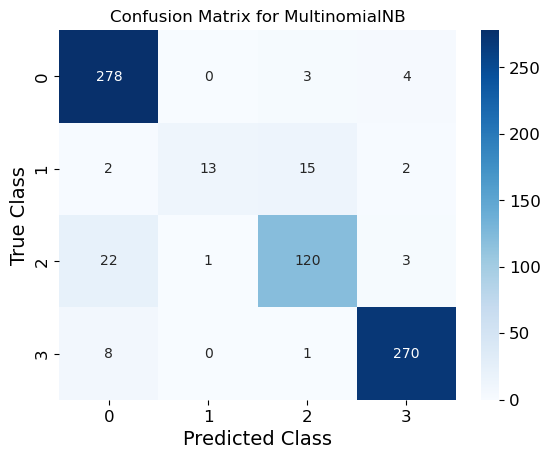

Classification report for SVC:
              precision    recall  f1-score   support

CNAF farming       0.93      0.99      0.96       285
    CNAF net       0.86      0.56      0.68        32
CNAF storage       0.92      0.90      0.91       146
       sysop       1.00      0.99      0.99       279

    accuracy                           0.95       742
   macro avg       0.93      0.86      0.89       742
weighted avg       0.95      0.95      0.95       742



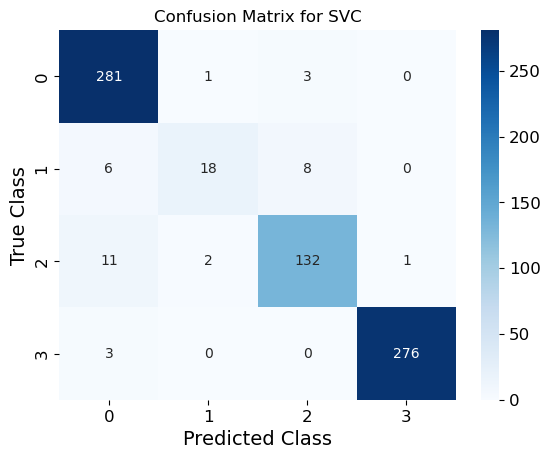

In [61]:
models = [nb, svm]
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    print(f"Classification report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues",fmt='d')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

In [62]:
# KNN needs this data structure
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)
y_train = np.ascontiguousarray(y_train)
y_test = np.ascontiguousarray(y_test)

**KNN models**

In [63]:
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

In [64]:
# Comparison of the accuracy of the 10 KNN models (TF-IDF)
from tabulate import tabulate
table1 = [['K', '1', '2', '3','4','5','6','7','8','9','10'],
          ['Accuracy', '0.91', '0.90', '0.93','0.92','0.92','0.91','0.90','0.91','0.91','0.90']]

print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤══════╤═════╤══════╤══════╤══════╤══════╤═════╤══════╤══════╤══════╕
│ K        │    1 │   2 │    3 │    4 │    5 │    6 │   7 │    8 │    9 │   10 │
╞══════════╪══════╪═════╪══════╪══════╪══════╪══════╪═════╪══════╪══════╪══════╡
│ Accuracy │ 0.91 │ 0.9 │ 0.93 │ 0.92 │ 0.92 │ 0.91 │ 0.9 │ 0.91 │ 0.91 │  0.9 │
╘══════════╧══════╧═════╧══════╧══════╧══════╧══════╧═════╧══════╧══════╧══════╛


Classification report for KNN with K = 3:

              precision    recall  f1-score   support

CNAF farming       0.96      0.93      0.94       285
    CNAF net       0.80      0.62      0.70        32
CNAF storage       0.81      0.92      0.86       146
       sysop       0.99      0.97      0.98       279

    accuracy                           0.93       742
   macro avg       0.89      0.86      0.87       742
weighted avg       0.93      0.93      0.93       742



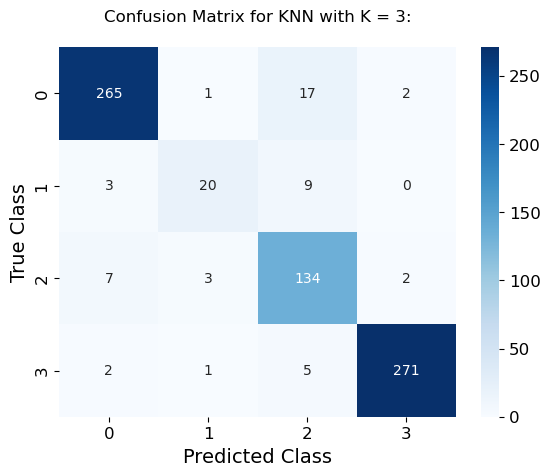

In [65]:
#k=3
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Classification report for KNN with K = {3}:\n")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues",fmt='d')
plt.title(f"Confusion Matrix for KNN with K = {3}:\n")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### WORD2VEC Models

In [66]:
df_w2v = pd.read_csv(f'{RESULTS_PATH}/user_support4_3.csv')

In [67]:
X_w2v = pd.read_csv(f'{RESULTS_PATH}/X.csv')

In [68]:
#We scale the matrix because the model doesn't accept negative values
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X_w2v)
X_scaled

array([[0.74030675, 0.21354594, 0.73024236, ..., 0.5149761 , 0.30224812,
        0.45423905],
       [0.61295098, 0.54060271, 0.62972591, ..., 0.51987339, 0.64441286,
        0.39392   ],
       [0.58555954, 0.9131763 , 0.41574437, ..., 0.25099453, 0.86078414,
        0.39450507],
       ...,
       [0.65337495, 0.48223809, 0.57948668, ..., 0.35495751, 0.42348854,
        0.47440364],
       [0.73718964, 0.45430956, 0.62128396, ..., 0.11243684, 0.32241921,
        0.56143844],
       [0.64494865, 0.39738344, 0.57547981, ..., 0.24970192, 0.31993802,
        0.5541484 ]])

In [69]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                        labels, test_size=0.2, random_state=1, 
                        stratify=labels)

In [70]:
# Training phase
nb.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC()

**NB and SVM models**

Classification report for MultinomialNB:
              precision    recall  f1-score   support

CNAF farming       0.57      0.94      0.71       285
    CNAF net       0.00      0.00      0.00        32
CNAF storage       0.00      0.00      0.00       146
       sysop       0.89      0.85      0.87       279

    accuracy                           0.68       742
   macro avg       0.36      0.45      0.39       742
weighted avg       0.55      0.68      0.60       742



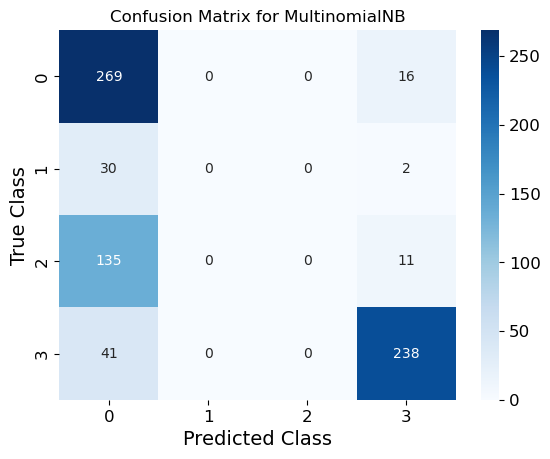

Classification report for SVC:
              precision    recall  f1-score   support

CNAF farming       0.91      0.95      0.93       285
    CNAF net       0.72      0.56      0.63        32
CNAF storage       0.87      0.82      0.85       146
       sysop       0.98      0.98      0.98       279

    accuracy                           0.92       742
   macro avg       0.87      0.83      0.85       742
weighted avg       0.92      0.92      0.92       742



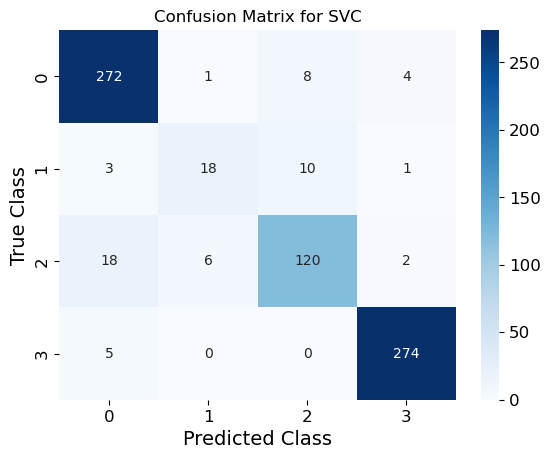

In [71]:
models = [nb, svm]
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    print(f"Classification report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues",fmt='d')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

**KNN models**

In [72]:
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)


In [75]:
# Comparison of the accuracy of the 10 KNN models (WORD2VEC)
table1 = [['K', '1', '2', '3','4','5','6','7','8','9','10'],
          ['Accuracy', '0.94', '0.92', '0.92','0.91','0.91','0.92','0.91','0.91','0.91','0.91']]
print(tabulate(table1, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│ K        │    1 │    2 │    3 │    4 │    5 │    6 │    7 │    8 │    9 │   10 │
╞══════════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│ Accuracy │ 0.94 │ 0.92 │ 0.92 │ 0.91 │ 0.91 │ 0.92 │ 0.91 │ 0.91 │ 0.91 │ 0.91 │
╘══════════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛


We chose k=3 rather than k=1 to avoid having a model too sensitive to noise in the data.

Classification report for KNN with K = 3:

              precision    recall  f1-score   support

CNAF farming       0.90      0.96      0.93       285
    CNAF net       0.73      0.59      0.66        32
CNAF storage       0.89      0.79      0.84       146
       sysop       0.97      0.98      0.97       279

    accuracy                           0.92       742
   macro avg       0.87      0.83      0.85       742
weighted avg       0.92      0.92      0.92       742



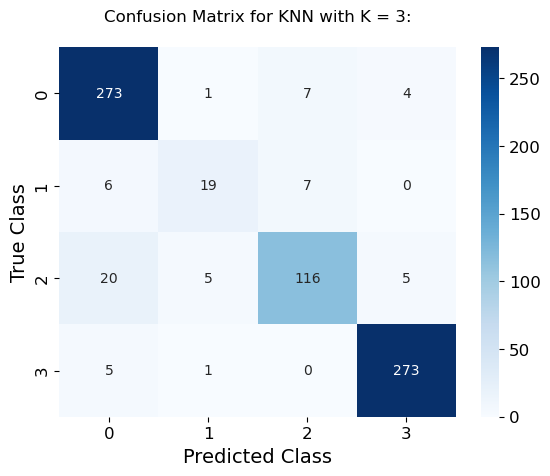

In [74]:
#k=3
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Classification report for KNN with K = {3}:\n")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues",fmt='d')
plt.title(f"Confusion Matrix for KNN with K = {3}:\n")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

## 6- RESULTS AND COMPARISONS

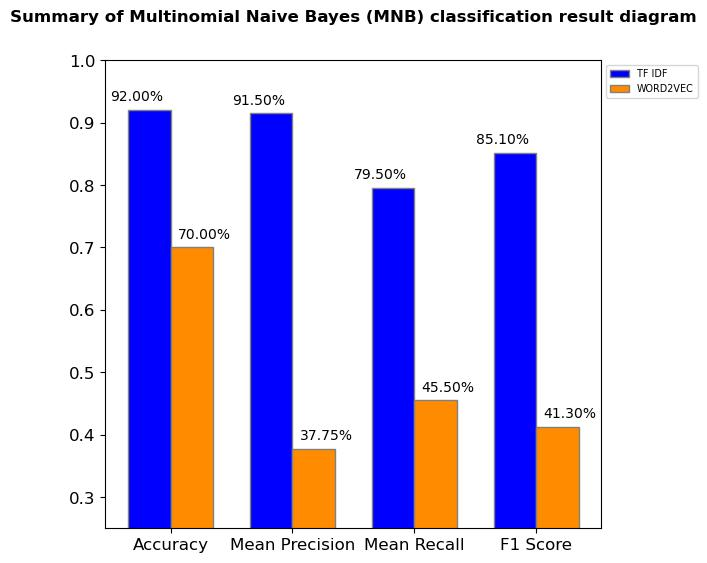

In [77]:
from IPython.display import Image 
MNB_barplot = f'{IMAGES_PATH}/MNB_barplot.png'
Image(MNB_barplot)

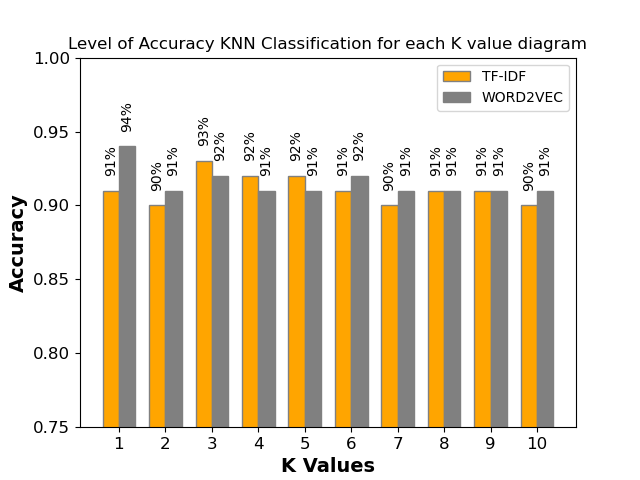

In [78]:
KNN_comparison = f'{IMAGES_PATH}/KNN_comparison.png'
Image(KNN_comparison)

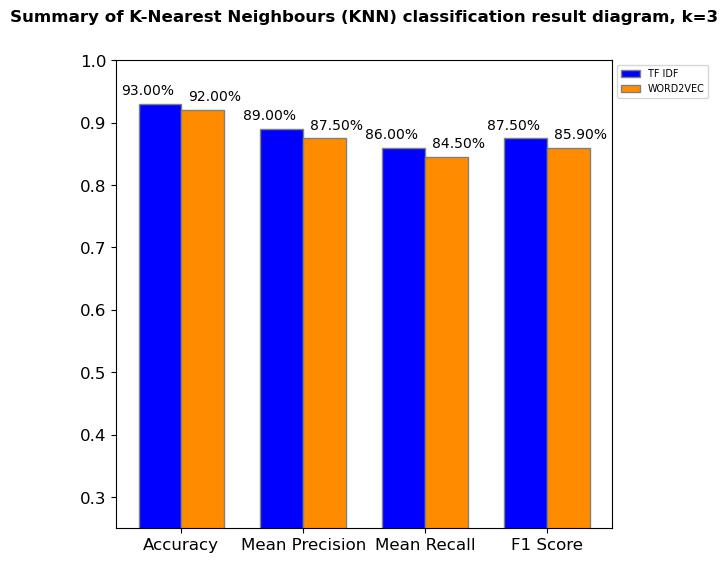

In [79]:
KNN3_barplot = f'{IMAGES_PATH}/KNN3_barplot.png'
Image(KNN3_barplot)

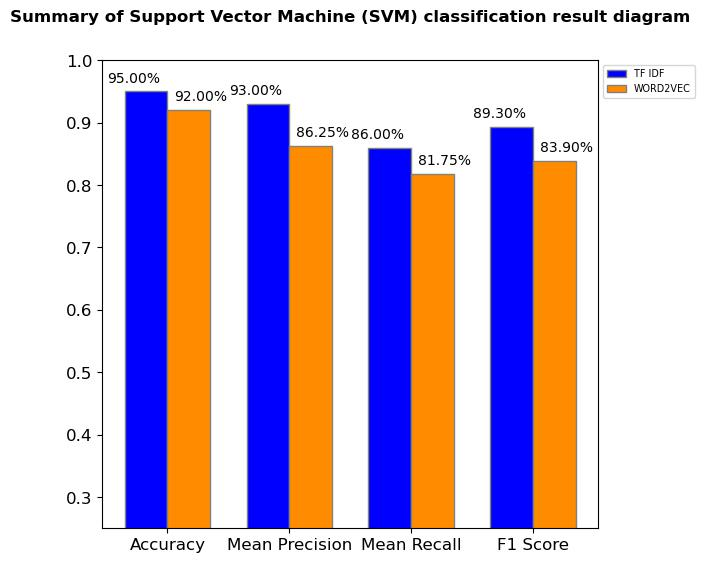

In [80]:
SVM_barplot = f'{IMAGES_PATH}/SVM_barplot.png'
Image(SVM_barplot)

**Classification Summary**

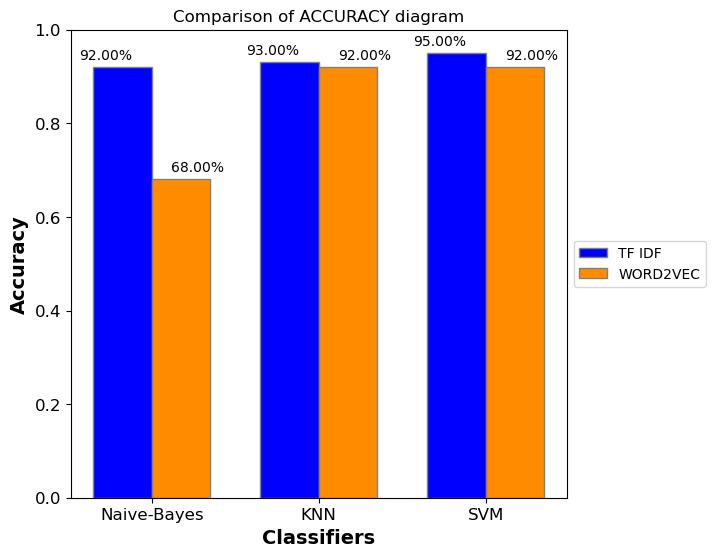

In [81]:
ACCURACY_comparison = f'{IMAGES_PATH}/ACCURACY_comparison.png'
Image(ACCURACY_comparison)

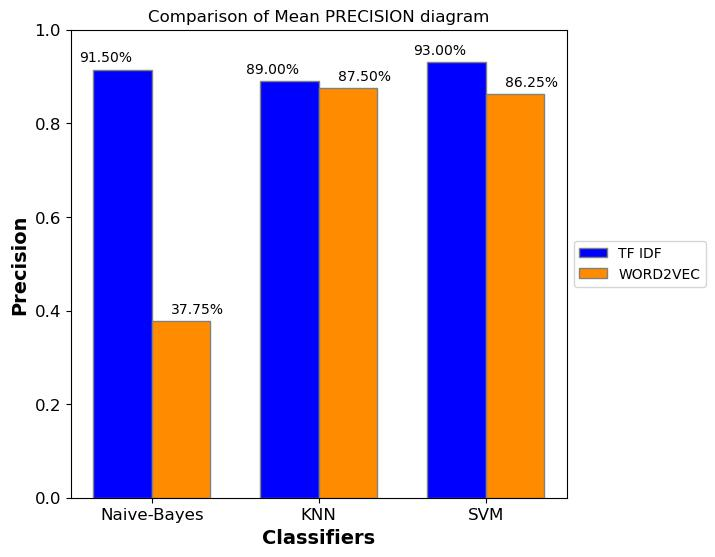

In [82]:
PRECISION_comparison = f'{IMAGES_PATH}/PRECISION_comparison.png'
Image(PRECISION_comparison)

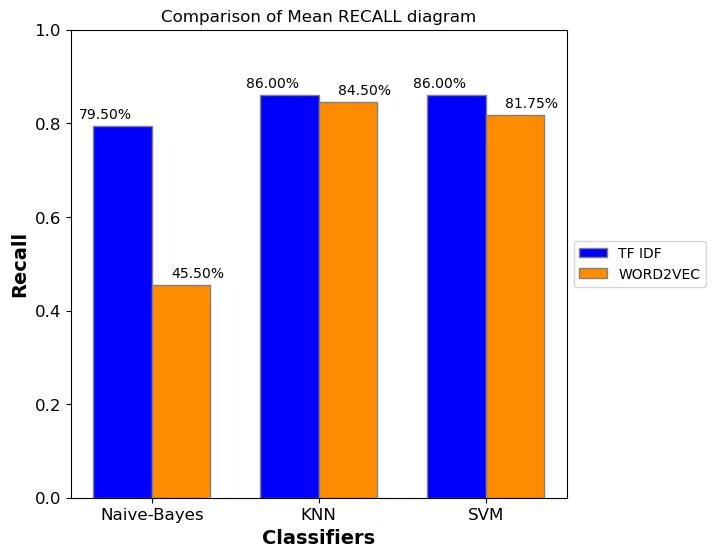

In [83]:
RECALL_Comparison = f'{IMAGES_PATH}/RECALL_comparison.png'
Image(RECALL_Comparison)

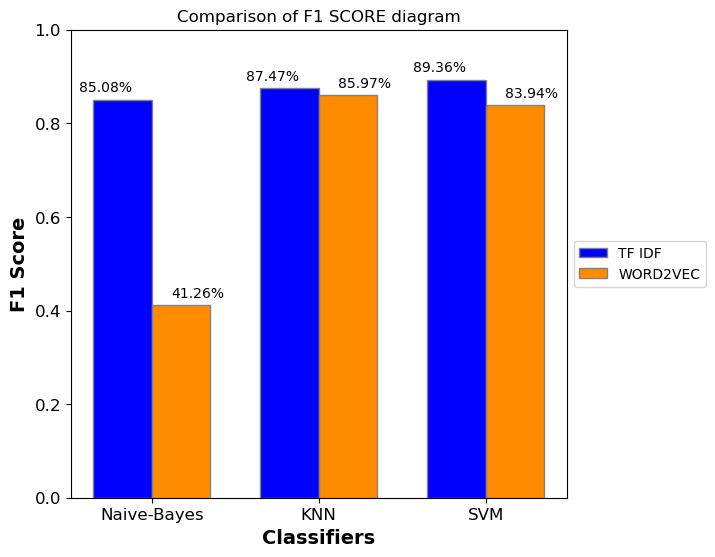

In [84]:
F1_SCORE_comparison = f'{IMAGES_PATH}/F1_SCORE_comparison.png'
Image(F1_SCORE_comparison)

## CONCLUSION:

The results of the classification carried out by each model in terms of performance and accuracy are satisfactory.   
In general, classification using the TF-IDF data feature has a better level of accuracy than using the WORD2VEC data 
feature.
The model with worst accuracy is the Naive-Bayes using Word2vec Features (Accuracy of 69%).   
The classification using **SVM model with TF-IDF Features is the most accurate**, with an accuracy of 95% and a F1-SCORE of 89.36%.